### Load Images, Create Heart Wall Mask, and Compute Distance Maps

This notebook demonstrates the process of loading heart images,
creating heart wall masks, and computing distance maps for analysis.
The steps include:

1. Collecting files from the "Edges" folder.
2. Selecting edges for no ablation ("NABL") images.
3. Building the heart slice using the `HeartSliceBuilder` class.
4. Visualizing the original image, heart wall mask, and distance map.

In [18]:
from pathlib import Path
import matplotlib.pyplot as plt
import fibrosisanalysis as fa
from tqdm.notebook import tqdm


path = Path('/Users/arstanbek/Library/CloudStorage/OneDrive-UGent/data')

hearts = ['E10615_MYH7',
          'E10621_ABCC9',
          'E10691_RBM20',
          'E10788_LMNA',
          'E10884',
          'E10927_MYBPC3',
          'E11442_TTN',
          'E11443_LMNA',
          'E11444_LMNA',
          'E11971_MYH7']

heart = hearts[0]

#! Collect files from "Edges" folder as not all images have manually labeled edges
files = [f.stem for f in path.joinpath(heart, "Edges").glob('*.npy')]
# Select edges for no ablation ("NABL") images
# There are two edges (endo and epi) so we select only one to avoid duplicates
files = [f for f in files if f.split("_")[-1] == "0" and "WABL" not in f]
files = ["_".join(f.split("_")[:-1]) for f in files]
files = sorted(files)

heart_slices = []

for filename in tqdm(files[:]):
    # Build the heart slice
    heart_slice_builder = fa.HeartSliceBuilder()
    heart_slice_builder.load_slice_data(path, heart, filename)
    heart_slice_builder.build_wall_mask()
    heart_slice_builder.compute_distance_map()

    heart_slice = heart_slice_builder.heart_slice
    heart_slice.heart = heart
    heart_slice.filename = filename
    heart_slices.append(heart_slice)


  0%|          | 0/19 [00:00<?, ?it/s]

### Select Random Sections from image

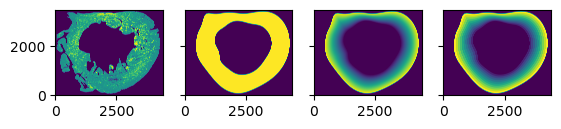

In [34]:
import numpy as np

heart_slice = heart_slices[7]

layers = np.digitize(heart_slice.distance_map, bins=np.linspace(0, 1, 11),
                     right=True)

%matplotlib inline
fig, axs = plt.subplots(ncols=4, sharex=True, sharey=True)
axs[0].imshow(heart_slice.image, origin='lower')
axs[1].imshow(heart_slice.wall_mask, origin='lower')
axs[2].imshow(heart_slice.distance_map, origin='lower')
axs[3].imshow(layers, origin='lower')
plt.show()

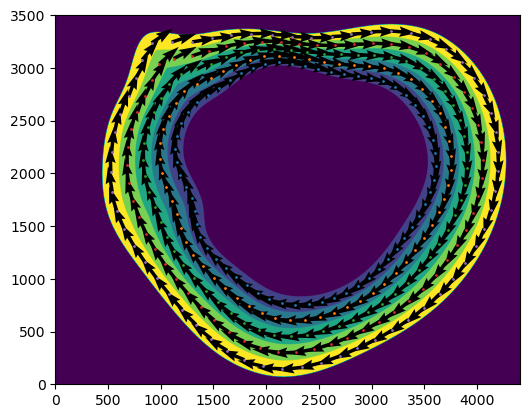

In [35]:
def compute_medial_axis(distance_map, n_rings=10, n_radials=None):
    layers = np.digitize(distance_map, bins=np.linspace(0, 1, n_rings + 1),
                         right=True)
    coords = []
    theta = []
    for l in range(1, layers.max() + 1):
        im = layers == l
        mg = fa.MedialGrid(im, min_hole_size=None)
        sp, sp_pos, sp_width = mg.compute_medial_spline()
        ma_len = mg.compute_medial_length(sp.nodes)
        ma_width = np.mean(sp_width)
        
        if n_radials is None:
            n_radials = int(1 / 2 * ma_len / ma_width)

        sp, sp_pos, sp_width = mg.compute_medial_spline(number_of_nodes=n_radials)
        radials = mg.compute_radial_lines(sp_pos, sp_width, n_rolls=2, n_avg=3)
        radials /= np.linalg.norm(radials, axis=1)[:, None]
        theta_ = np.pi / 2 + np.arctan2(radials[:, 0], radials[:, 1])
        theta_ = np.unwrap(theta_)
        coords.append(sp_pos)
        theta.append(theta_)

    return layers, coords, theta


layers, direct_coords, theta = compute_medial_axis(heart_slice.distance_map,
                                                   n_rings=5)

%matplotlib inline

fig, ax = plt.subplots()
ax.imshow(layers, origin='lower')
for l in range(1, layers.max() + 1):
    ax.plot(direct_coords[l-1][:, 1], direct_coords[l-1][:, 0], 'o', ms=1)
    ax.quiver(direct_coords[l-1][:, 1], direct_coords[l-1][:, 0],
              np.cos(theta[l-1]), np.sin(theta[l-1]))
plt.show()

direct_coords = np.row_stack(direct_coords)
theta = np.concatenate(theta)

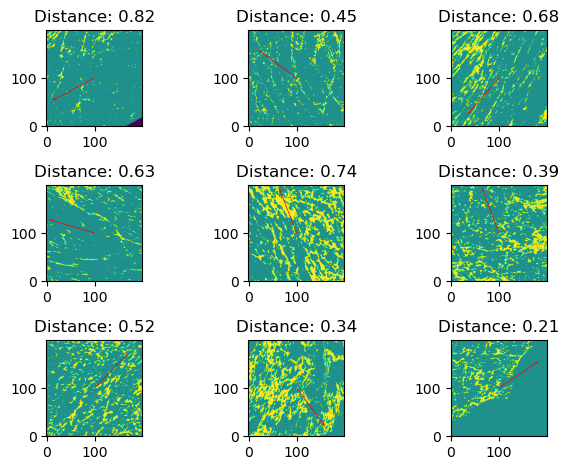

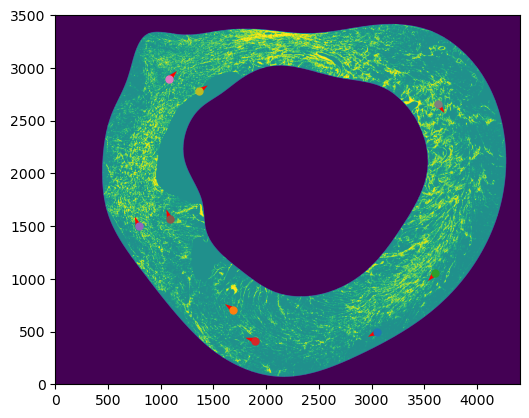

In [37]:
import numpy as np
from scipy import spatial

wall_mask = heart_slice.wall_mask
distance_map = heart_slice.distance_map
image = heart_slice.image.copy()
image[wall_mask & (image == 0)] = 1
image[~wall_mask] = 0

template_size = 200
num_of_sections = 9
points = np.argwhere(heart_slice.wall_mask)
np.random.shuffle(points)

tree = spatial.cKDTree(direct_coords)

sections = []
for point in points:
    i_min = max(0, point[0] - template_size // 2)
    i_max = min(image.shape[0], i_min + template_size)
    j_min = max(0, point[1] - template_size // 2)
    j_max = min(image.shape[1], j_min + template_size)

    if ((i_max - i_min) < template_size) or ((j_max - j_min) < template_size):
        continue

    template = image[i_min:i_max, j_min:j_max]

    if (np.count_nonzero(template) / template.size) < 0.99:
        continue

    endo_epi_dist = distance_map[point[0], point[1]]

    sections.append({"image": template,
                     "center": point,
                     "dist": endo_epi_dist,
                     "direction": theta[tree.query(point)[1]]})

    if len(sections) >= num_of_sections:
        break

%matplotlib inline
fig, axs = plt.subplots(ncols=3, nrows=3)
for i, section in enumerate(sections):
    ax = axs.flat[i]
    ax.imshow(section["image"], vmin=0, vmax=2, origin='lower')
    ax.quiver(template_size // 2, template_size // 2,
              template_size // 2 * np.cos(section["direction"]),
              template_size // 2 * np.sin(section["direction"]),
              color='r', scale=1, scale_units='xy', angles='xy'
              )
    ax.set_title(f"Distance: {section['dist']:.2f}")

plt.tight_layout()
plt.show()

%matplotlib inline
plt.figure()
plt.imshow(image, origin='lower')
for section in sections:
    plt.plot(section["center"][1], section["center"][0], 'o', ms=5)
    plt.quiver(section["center"][1], section["center"][0],
                template_size // 2 * np.cos(section["direction"]),
                template_size // 2 * np.sin(section["direction"]),
                color='r', scale=1, scale_units='xy', angles='xy'
                )
plt.show()
